# README
Dear participants,

Your task is to create a trading strategy that maximizes profits and minimizes risks using the training dataset. The training dataset contains daily prices for 12 stocks from 4 sectors. Strategies must be backtested using the zipline platform, the installation and usage of which is demonstrated in this notebook. An example strategy (called a Moving Average crossover strategy) is shown below.

What is a strategy?
>A strategy is simply an algorithm that takes in price data (Open, High, Low, Close and Volume) and outputs either a buy or sell signal for the current point in time.

What is backtesting?
>Backtesting is a method used to test a trading strategy using historical data. At each point in time, the algorithm is passed price data upto that point - based on which the algorithm outputs a decision to buy/sell/do nothing. In this way, the performance of a strategy can be estimated based on past data.

What are the most important metrics for evaluation?
1. **(Final) Portfolio value** - the higher the better
2. **(Average) Sharpe ratio** measures risk-adjusted returns of a returns series. Put simply, it is the expected return divided by the volatility, so the higher it is, the better. An n-period rolling sharpe ratio simply calculates the annualized sharpe ratio for the last n periods. We will be focusing on this rolling 30-day sharpe ratio as the most important metric for evaluation. However, we are interested in both the stability of the rolling sharpe ratio as well as its actual value.
3. **(Max) Drawdown** is a measure of the highest amount of money that the strategy loses compared to its previous peak. Plotting drawdowns provides a good picture of the risks associated with a strategy.

# Team S
## Members : 
### Name: Nazmus Sakib Ahmed  ;  Email: bsse1108@iit.du.ac.bd  (Team Leader)
### Name: Inzamam-Ul-Huq Sobuz ;  Email: bsse1113@iit.du.ac.bd
### Name: Ashraful Islam Shanto Sikder  ;  Email: bsse1124@iit.du.ac.bd

# Strategy:
### We used a polynomial regression predict the trend of the assets. We attempted capture the price of an asset as a function of time where time was expressed as the day number starting from 0 and incremented each day.  Then we optimized the performance with MACD, short for moving average convergence/divergence, which is a classic analysis technique in trading

In [1]:
!pip install zipline-reloaded

In [2]:
!pip install PyPortfolioOpt
!pip install sklearn

In [3]:
%load_ext autoreload

In [4]:
# ingesting, registering calender by calling functions from zipline
%autoreload 2
import calendar
import os
import pandas as pd
from datetime import datetime, timezone
from zipline.data import bundles as bundles_module
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.api import symbol, schedule_function, date_rules, time_rules
from zipline.api import order_target, order_percent, order_target_percent, record, symbol
import matplotlib.pyplot as plt
from utils import *
import stats
import talib as ta
from zipline.finance import commission
import numpy as np 
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression



## First we will ingest the training dataset

In [5]:
%%capture warnings
calendar_name = 'NYSE'
register("stockdata", csvdir_equities(["daily"],'train/'),calendar_name=calendar_name)
bundles_module.ingest("stockdata")

 | ACG: sid 0
 | BTL: sid 1
 | CFL: sid 2
 | DFT: sid 3
 | FE: sid 4
 | JZIL: sid 5
 | KWF: sid 6
 | LS: sid 7
 | MUN: sid 8
 | NAB: sid 9
 | NIH: sid 10
 | VME: sid 11


### (optional) The data can be loaded and viewed using the dailyBars object
You may also choose to work with the csv files themselves

In [6]:
names = "DFT, ACG, LS, CFL, NAB, BTL, KWF, FE, JZIL, MUN, NIH, VME"
stocks = [x for x in names.split(", ")]
bundle = 'stockdata'
start="2003-07-03"
end = "2004-07-06"
db_obj = dailyBars(coins=stocks, bundle=bundle, calendar=get_calendar("NYSE"))

In [7]:
db_obj.ohlcvData(start, end, value_list=['open', 'close'])

open                                            \
                             DFT    ACG     LS    CFL    NAB    BTL    KWF   
2003-07-03 00:00:00+00:00  2.797  0.782  0.407  1.420  2.883  1.029  0.593   
2003-07-07 00:00:00+00:00  2.831  0.787  0.408  1.446  2.873  1.035  0.604   
2003-07-08 00:00:00+00:00  2.851  0.794  0.401  1.444  2.879  1.043  0.582   
2003-07-09 00:00:00+00:00  2.874  0.796  0.407  1.457  2.895  1.054  0.515   
2003-07-10 00:00:00+00:00  2.864  0.795  0.406  1.464  2.907  1.047  0.486   
...                          ...    ...    ...    ...    ...    ...    ...   
2004-06-29 00:00:00+00:00  2.897  0.779  0.310  1.706  2.950  0.837  0.339   
2004-06-30 00:00:00+00:00  2.919  0.795  0.323  1.711  2.999  0.843  0.341   
2004-07-01 00:00:00+00:00  2.900  0.788  0.318  1.679  2.979  0.837  0.337   
2004-07-02 00:00:00+00:00  2.826  0.757  0.306  1.640  2.924  0.816  0.340   
2004-07-06 00:00:00+00:00  2.786  0.735  0.303  1.626  2.894  0.796  0.359   

                                                ...  close                \
                              FE   JZIL    MUN  ...     LS    CFL    NAB   
2003-07-03 00:00:00+00:00  2.741  3.418  6.610  ...  0.409  1.439  2.873   
2003-07-07 00:00:00+00:00  2.737  3.446  6.687  ...  0.407  1.448  2.886   
2003-07-08 00:00:00+00:00  2.730  3.454  6.688  ...  0.402  1.452  2.896   
2003-07-09 00:00:00+00:00  2.730  3.506  6.718  ...  0.406  1.460  2.907   
2003-07-10 00:00:00+00:00  2.745  3.549  6.730  ...  0.407  1.474  2.921   
...                          ...    ...    ...  ...    ...    ...    ...   
2004-06-29 00:00:00+00:00  2.278  3.414  6.686  ...  0.313  1.715  3.003   
2004-06-30 00:00:00+00:00  2.359  3.403  6.783  ...  0.317  1.672  2.994   
2004-07-01 00:00:00+00:00  2.273  3.371  6.594  ...  0.311  1.652  2.932   
2004-07-02 00:00:00+00:00  2.195  3.240  6.608  ...  0.308  1.647  2.938   
2004-07-06 00:00:00+00:00  2.146  3.127  6.566  ...  0.299  1.583  2.879   

                                                                            
                             BTL    KWF     FE   JZIL    MUN    NIH    VME  
2003-07-03 00:00:00+00:00  1.031  0.602  2.741  3.442  6.677  8.676  6.776  
2003-07-07 00:00:00+00:00  1.045  0.603  2.735  3.454  6.707  8.741  6.814  
2003-07-08 00:00:00+00:00  1.047  0.517  2.726  3.478  6.695  8.714  6.818  
2003-07-09 00:00:00+00:00  1.043  0.492  2.739  3.550  6.718  8.679  6.814  
2003-07-10 00:00:00+00:00  1.046  0.472  2.716  3.484  6.748  8.744  6.882  
...                          ...    ...    ...    ...    ...    ...    ...  
2004-06-29 00:00:00+00:00  0.844  0.338  2.306  3.404  6.746  7.731  8.001  
2004-06-30 00:00:00+00:00  0.839  0.339  2.291  3.372  6.590  8.063  7.867  
2004-07-01 00:00:00+00:00  0.820  0.321  2.210  3.247  6.596  8.103  7.822  
2004-07-02 00:00:00+00:00  0.810  0.366  2.192  3.189  6.617  7.987  7.759  
2004-07-06 00:00:00+00:00  0.784  0.361  2.118  3.115  6.485  7.790  7.573  

[253 rows x 24 columns]

# Backtesting 
Backtesting a strategy in zipline involves two functions:
1. initialize: which is invoked once at the start of the backtest. It initializes the context object which is available to the algorithm at each step of backtesting.
The context object can be used to store variables that can be accessed through the backtest.
2. handle_data: this is invoked once for every date in the dataset. The rules for the strategy must be referred to within this function. To access the price data, we call the data object. 

For more information, visit [zipline documentation](https://zipline.ml4trading.io/beginner-tutorial)

In [8]:
%%capture multicap
bundle = 'stockdata'
start="2003-09-13"
end = "2004-07-06"
capital_base = 100000
calendar = get_calendar('NYSE')
    

def initialize(context):
    bundle_data = bundles.load(bundle)
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.capital = capital_base
    context.n_asset = len(context.assets)
    context.window = 60
    context.time = 0
    
    
def handle_data(context, data):
    if context.time<context.window:
        context.time += 1
        return
        
    for asset in context.assets:
        prices = data.history(asset, fields='price',
                              bar_count=context.window, frequency='1d')
        serial= np.arange(0,context.window,1);
        mean= data.history(asset,fields='price',bar_count=context.window,frequency='1d').mean();
        lastDat=data.history(asset,fields='price',bar_count=5,frequency='1d');
        X_train, X_test, y_train, y_test = train_test_split(serial, prices, test_size=.3, random_state=4)
        X_train=X_train.reshape(-1,1);
        y_train=y_train.to_numpy().reshape(-1,1);
        poly = PolynomialFeatures(degree=9, include_bias=True);
        poly_features=poly.fit_transform(X_train);
        poly_reg_model = LinearRegression()
        poly_reg_model.fit(poly_features, y_train)
        curX=poly.fit_transform([[context.time]]);
        pred=poly_reg_model.predict(curX)
        
        price_history = data.history(asset, fields="price", bar_count=34, frequency="1d")
        macd, macdsignal, macdhist = ta.MACD(price_history, 12, 26, 9) 
        
        if data.can_trade(asset) and not get_open_orders(asset):      
            if (macdsignal[-1] > macd[-1]):
                order_target(asset, 0)

            elif pred>lastDat[4]:
                order_target_percent(asset,.09)

    context.time += 1
                
    
result = run_algorithm(start=pd.Timestamp(start, tz='utc'),
                        end=pd.Timestamp(end, tz='utc'),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='stockdata',
                        data_frequency='daily',
                        )


In [9]:
result

,period_open,period_close,ending_value,starting_cash,ending_cash,portfolio_value,longs_count,shorts_count,long_value,short_value,...,trading_days,period_label,algorithm_period_return,algo_volatility,benchmark_period_return,benchmark_volatility,alpha,beta,sharpe,sortino
2003-09-15 20:00:00+00:00,2003-09-15 13:31:00+00:00,2003-09-15 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,1,2003-09,0.000000,NaN,0.0,NaN,None,None,NaN,NaN
2003-09-16 20:00:00+00:00,2003-09-16 13:31:00+00:00,2003-09-16 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,2,2003-09,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
2003-09-17 20:00:00+00:00,2003-09-17 13:31:00+00:00,2003-09-17 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,3,2003-09,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
2003-09-18 20:00:00+00:00,2003-09-18 13:31:00+00:00,2003-09-18 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,4,2003-09,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
2003-09-19 20:00:00+00:00,2003-09-19 13:31:00+00:00,2003-09-19 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,5,2003-09,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-06-29 20:00:00+00:00,2004-06-29 13:31:00+00:00,2004-06-29 20:00:00+00:00,33207.407,76197.815870,77983.119907,111190.526907,4,0,33207.407,0.0,...,199,2004-06,0.111905,0.069280,0.0,0.0,None,None,1.973817,3.225001
2004-06-30 20:00:00+00:00,2004-06-30 13:31:00+00:00,2004-06-30 20:00:00+00:00,30527.945,77983.119907,80538.593484,111066.538484,4,0,30527.945,0.0,...,200,2004-06,0.110665,0.069131,0.0,0.0,None,None,1.947864,3.182316
2004-07-01 20:00:00+00:00,2004-07-01 13:31:00+00:00,2004-07-01 20:00:00+00:00,38815.767,80538.593484,71282.511306,110098.278306,4,0,38815.767,0.0,...,201,2004-07,0.100983,0.069732,0.0,0.0,None,None,1.764733,2.840475
2004-07-02 20:00:00+00:00,2004-07-02 13:31:00+00:00,2004-07-02 20:00:00+00:00,28873.987,71282.511306,80968.079763,109842.066763,3,0,28873.987,0.0,...,202,2004-07,0.098421,0.069629,0.0,0.0,None,None,1.716891,2.761268


Starting portfolio value: 100000.0
Final portfolio value: 109080.55065649995
Average sharpe: 1.8464803802519423
Max drawdown: -0.023640961018676705


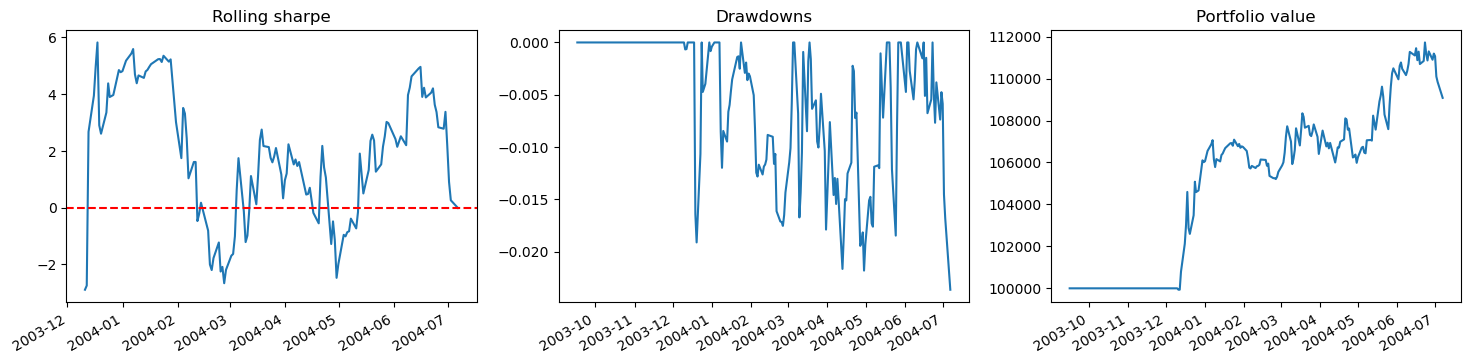

,period_open,period_close,ending_value,starting_cash,ending_cash,portfolio_value,longs_count,shorts_count,long_value,short_value,...,algo_volatility,benchmark_period_return,benchmark_volatility,alpha,beta,sharpe,sortino,rolling_sharpe,rolling_vol,drawdowns
2003-09-15 20:00:00+00:00,2003-09-15 13:31:00+00:00,2003-09-15 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,NaN,0.0,NaN,None,None,NaN,NaN,NaN,NaN,NaN
2003-09-16 20:00:00+00:00,2003-09-16 13:31:00+00:00,2003-09-16 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,0.000000
2003-09-17 20:00:00+00:00,2003-09-17 13:31:00+00:00,2003-09-17 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,0.000000
2003-09-18 20:00:00+00:00,2003-09-18 13:31:00+00:00,2003-09-18 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,0.000000
2003-09-19 20:00:00+00:00,2003-09-19 13:31:00+00:00,2003-09-19 20:00:00+00:00,0.000,100000.000000,100000.000000,100000.000000,0,0,0.000,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-06-29 20:00:00+00:00,2004-06-29 13:31:00+00:00,2004-06-29 20:00:00+00:00,33207.407,76197.815870,77983.119907,111190.526907,4,0,33207.407,0.0,...,0.069280,0.0,0.0,None,None,1.973817,3.225001,3.374663,0.005261,-0.004755
2004-06-30 20:00:00+00:00,2004-06-30 13:31:00+00:00,2004-06-30 20:00:00+00:00,30527.945,77983.119907,80538.593484,111066.538484,4,0,30527.945,0.0,...,0.069131,0.0,0.0,None,None,1.947864,3.182316,2.192121,0.004814,-0.005865
2004-07-01 20:00:00+00:00,2004-07-01 13:31:00+00:00,2004-07-01 20:00:00+00:00,38815.767,80538.593484,71282.511306,110098.278306,4,0,38815.767,0.0,...,0.069732,0.0,0.0,None,None,1.764733,2.840475,0.904485,0.005094,-0.014531
2004-07-02 20:00:00+00:00,2004-07-02 13:31:00+00:00,2004-07-02 20:00:00+00:00,28873.987,71282.511306,80968.079763,109842.066763,3,0,28873.987,0.0,...,0.069629,0.0,0.0,None,None,1.716891,2.761268,0.256493,0.005068,-0.016825


In [10]:
stats.show_rolling_stats(result, 30)

### And that's all. Please reach out on the [slack channel](https://join.slack.com/share/enQtNDQzNDkyNDY4OTIwNS02MmU1YjY4MTI2YjAxZmIwYTI1ZjcyYjEzOGFkODc4MGE0YTJmMWU4ZTU2OGRhZmJkNWFiZDkwOGI4YmJhOTk4) if you have any queries, questions or even suggestions. Happy coding!